In [1]:
# --- Import necessary libraries ---
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
import seaborn as sns
from cluster_function import *
import os

In [2]:
# --- Block averaging function for estimating statistical uncertainty ---
# Accepts a time series and returns error estimates using block averaging.
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
        #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum((x[0:(n-1)]-mu)*(x[1:n]-mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
               16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
               24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
               31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
               38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
               45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))

In [3]:
def get_blockerrors_pyblock(Data, bound_frac, max_levels=15):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)

            # Limit number of block levels to `max_levels`
            max_blocks = min(len(reblock_data), max_levels)
            reblock_data = reblock_data[:max_blocks]

            opt = int(pyblock.blocking.find_optimal_block(len(data), reblock_data)[0])
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave) / bound_frac
    be_bf = np.asarray(block_errors) / bound_frac
    return ave_bf, be_bf

In [4]:
# --- Define input and output directories ---
workdir = '/home/daisy/Documents/Research/Anton/R2_dimer/Zhu_et_al_3.31.25/'
outdir = workdir + 'compare_all/'
trajdir = workdir + 'trajectory/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

pdb = trajdir + 'R2_dimer.pdb'
apo_dcd = trajdir + 'apo.protein.100us.stride100.dcd'
E2_dcd = trajdir + 'E2.protein.100us.stride100.dcd'
AA_dcd = trajdir + '1AA.protein.85us.stride100.dcd'

E2_pdb = trajdir + 'R2_dimer_epi002.pdb'
AA_pdb = trajdir + 'R2_dimer_1aa.pdb'
E2_ligand_dcd = trajdir + 'E2.protein.ligand.100us.stride100.dcd'
AA_ligand_dcd = trajdir + '1AA.protein.ligand.85us.stride100.dcd'

In [5]:
# --- Load full-resolution trajectories ---
stride_n = 1

apo_trj = md.load(apo_dcd, top=pdb, stride = stride_n)
E2_trj = md.load(E2_dcd, top=pdb, stride = stride_n)
AA_trj = md.load(AA_dcd, top=pdb, stride = stride_n)

top = apo_trj.topology

print(apo_trj)
print(E2_trj)
print(AA_trj)

<mdtraj.Trajectory with 416660 frames, 676 atoms, 52 residues, and unitcells>
<mdtraj.Trajectory with 416660 frames, 676 atoms, 52 residues, and unitcells>
<mdtraj.Trajectory with 374000 frames, 676 atoms, 52 residues, and unitcells>


In [6]:
# --- Load full-resolution trajectories ---
apo_trjH1 = md.load(apo_dcd, top=pdb, stride = stride_n)
apo_trjH2 = md.load(apo_dcd, top=pdb, stride = stride_n)
E2_trjH1 = md.load(E2_dcd, top=pdb, stride = stride_n)
E2_trjH2 = md.load(E2_dcd, top=pdb, stride = stride_n)
AA_trjH1 = md.load(AA_dcd, top=pdb, stride = stride_n)
AA_trjH2 = md.load(AA_dcd, top=pdb, stride = stride_n)

H1 = top.select("residue 1 to 24")
H2 = top.select("residue 27 to 50")

apo_trjH1.restrict_atoms(H1)
apo_trjH2.restrict_atoms(H2)
E2_trjH1.restrict_atoms(H1)
E2_trjH2.restrict_atoms(H2)
AA_trjH1.restrict_atoms(H1)
AA_trjH2.restrict_atoms(H2)

apo_trjH1.center_coordinates()
apo_trjH2.center_coordinates()
E2_trjH1.center_coordinates()
E2_trjH2.center_coordinates()
AA_trjH1.center_coordinates()
AA_trjH2.center_coordinates()

<mdtraj.Trajectory with 374000 frames, 329 atoms, 24 residues, and unitcells at 0x7f87ca751f10>

In [7]:
# --- Calculate statistical measures ---
def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float)/len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if(np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E


apo_dsspH1 = md.compute_dssp(apo_trjH1, simplified=True)
apo_dsspH2 = md.compute_dssp(apo_trjH2, simplified=True)
E2_dsspH1 = md.compute_dssp(E2_trjH1, simplified=True)
E2_dsspH2 = md.compute_dssp(E2_trjH2, simplified=True)
AA_dsspH1 = md.compute_dssp(AA_trjH1, simplified=True)
AA_dsspH2 = md.compute_dssp(AA_trjH2, simplified=True)

apo_H1_H, apo_H1_E = dssp_convert(apo_dsspH1)
apo_H2_H, apo_H2_E = dssp_convert(apo_dsspH2)
E2_H1_H, E2_H1_E = dssp_convert(E2_dsspH1)
E2_H2_H, E2_H2_E = dssp_convert(E2_dsspH2)
AA_H1_H, AA_H1_E = dssp_convert(AA_dsspH1)
AA_H2_H, AA_H2_E = dssp_convert(AA_dsspH2)

apo_H = np.average([apo_H1_H, apo_H2_H], axis=0)
E2_H = np.average([E2_H1_H, E2_H2_H], axis=0)
AA_H = np.average([AA_H1_H, AA_H2_H], axis=0)

In [8]:
#save apo_dsspH1, apo_dsspH2, E2_dsspH1, E2_dsspH2, AA_dsspH1, AA_dsspH2
np.save(outdir + 'apo_H1_H.npy', apo_dsspH1)
np.save(outdir + 'apo_H2_H.npy', apo_dsspH2)
np.save(outdir + 'E2_H1_H.npy', E2_dsspH1)
np.save(outdir + 'E2_H2_H.npy', E2_dsspH2)
np.save(outdir + 'AA_H1_H.npy', AA_dsspH1)
np.save(outdir + 'AA_H2_H.npy', AA_dsspH2)


In [9]:
sequence = []
for i in range(1, 26):
    new_i = i+390
    if i % 3 == 1:
        sequence.append(str(top.residue(i).name) + str(new_i))
    elif i == 24:
        sequence.append(str(top.residue(i).name) + str(new_i))
    else: 
        sequence.append('')

sequence_ol = []
for i in range(1, 25):
    sequence_ol.append(str(top.residue(i).code))
print(sequence_ol)

['L', 'D', 'Y', 'G', 'S', 'A', 'W', 'A', 'A', 'A', 'A', 'A', 'Q', 'C', 'R', 'Y', 'G', 'D', 'L', 'A', 'S', 'L', 'H', 'G']


In [10]:
clist = ['#8c564b', '#ff7f0e', '#d62728']

In [11]:
clist_old = ['red', 'blue', 'darkgreen']

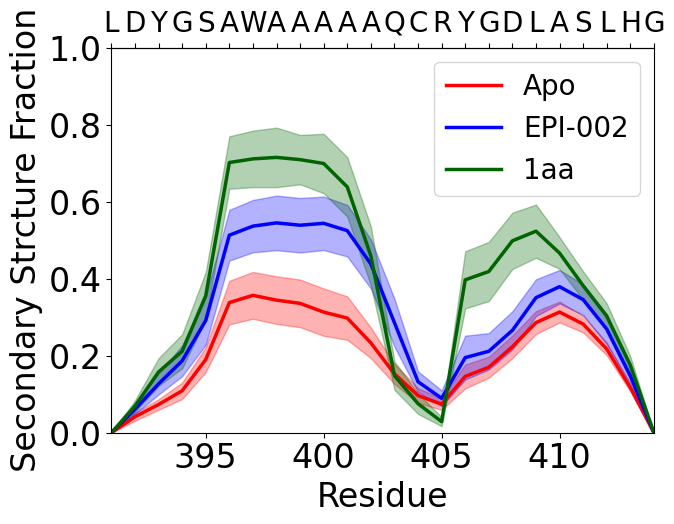

In [12]:
# --- Plotting results ---
prot_top = apo_trjH1.topology.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)

residues = 24
residue_offset = 390
prot_res_renum = np.asarray(prot_res)+residue_offset

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(prot_res_renum, apo_H[:, 0], linewidth = 2.5, label='Apo', c = clist_old[0])
ax.fill_between(prot_res_renum, apo_H[:, 0]-apo_H[:, 1], apo_H[:, 0]+apo_H[:, 1], alpha=0.3, color = clist_old[0])
ax.plot(prot_res_renum, E2_H[:, 0], linewidth = 2.5, label='EPI-002', c = clist_old[1])
ax.fill_between(prot_res_renum, E2_H[:, 0]-E2_H[:, 1], E2_H[:, 0]+E2_H[:, 1], alpha=0.3, color = clist_old[1])
ax.plot(prot_res_renum, AA_H[:, 0], linewidth = 2.5, label='1aa', c = clist_old[2])
ax.fill_between(prot_res_renum, AA_H[:, 0]-AA_H[:, 1], AA_H[:, 0]+AA_H[:, 1], alpha=0.3, color = clist_old[2])

ax.set_ylim(0, 1.0)
ax.set_xlim(391, 414)
ax.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel('Residue', size=24)
ax.set_ylabel('Secondary Strcture Fraction', size=24)
plt.tick_params(labelsize=24)

secax1 = ax.secondary_xaxis('top')
# secax1.grid(which='both', alpha=0.5)
# secax2.grid(which='both', alpha=0.5)
# secax1.xaxis.set_minor_locator(AutoMinorLocator(2))
secax1.set_xticks(range(391, 391+24))
secax1.set_xticklabels(sequence_ol)
secax1.tick_params(labelsize=20)

plt.savefig(outdir+'Tau5_R2_average_helix_C1.pdf', dpi=300, bbox_inches='tight')
plt.savefig(outdir+'Tau5_R2_average_helix_C1.svg', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
top = AA_trj.topology

In [14]:
H1_CA = top.select("residue 1 to 24 and name CA")
H2_CA = top.select("residue 27 to 50 and name CA")

H1_atomid = []
for atom in H1_CA:
    H1_atomid.append(top.atom(atom))

H2_atomid = []
for atom in H2_CA:
    H2_atomid.append(top.atom(atom))

print(H1_CA)
print(H2_CA)
print(H1_atomid)
print(H2_atomid)


def add_contact_pair(pairs, resA, resB, contact_prob):
    if resA not in pairs:
        pairs[resA] = {}
    if resB not in pairs[resA]:
        pairs[resA][resB] = {}
    pairs[resA][resB] = contact_prob


CA_pairs = []
for i in H1_CA:
    for j in H2_CA:
        CA_pairs.append([i, j])

[  8  27  39  60  67  78  88 112 122 132 142 152 162 179 190 214 235 242
 254 273 283 294 313 330]
[346 365 377 398 405 416 426 450 460 470 480 490 500 517 528 552 573 580
 592 611 621 632 651 668]
[LEU1-CA, ASP2-CA, TYR3-CA, GLY4-CA, SER5-CA, ALA6-CA, TRP7-CA, ALA8-CA, ALA9-CA, ALA10-CA, ALA11-CA, ALA12-CA, GLN13-CA, CYS14-CA, ARG15-CA, TYR16-CA, GLY17-CA, ASP18-CA, LEU19-CA, ALA20-CA, SER21-CA, LEU22-CA, HIS23-CA, GLY24-CA]
[LEU27-CA, ASP28-CA, TYR29-CA, GLY30-CA, SER31-CA, ALA32-CA, TRP33-CA, ALA34-CA, ALA35-CA, ALA36-CA, ALA37-CA, ALA38-CA, GLN39-CA, CYS40-CA, ARG41-CA, TYR42-CA, GLY43-CA, ASP44-CA, LEU45-CA, ALA46-CA, SER47-CA, LEU48-CA, HIS49-CA, GLY50-CA]


In [15]:
for i  in CA_pairs:
    print(i)
    print(top.atom(i[0]), top.atom(i[1]))

[8, 346]
LEU1-CA LEU27-CA
[8, 365]
LEU1-CA ASP28-CA
[8, 377]
LEU1-CA TYR29-CA
[8, 398]
LEU1-CA GLY30-CA
[8, 405]
LEU1-CA SER31-CA
[8, 416]
LEU1-CA ALA32-CA
[8, 426]
LEU1-CA TRP33-CA
[8, 450]
LEU1-CA ALA34-CA
[8, 460]
LEU1-CA ALA35-CA
[8, 470]
LEU1-CA ALA36-CA
[8, 480]
LEU1-CA ALA37-CA
[8, 490]
LEU1-CA ALA38-CA
[8, 500]
LEU1-CA GLN39-CA
[8, 517]
LEU1-CA CYS40-CA
[8, 528]
LEU1-CA ARG41-CA
[8, 552]
LEU1-CA TYR42-CA
[8, 573]
LEU1-CA GLY43-CA
[8, 580]
LEU1-CA ASP44-CA
[8, 592]
LEU1-CA LEU45-CA
[8, 611]
LEU1-CA ALA46-CA
[8, 621]
LEU1-CA SER47-CA
[8, 632]
LEU1-CA LEU48-CA
[8, 651]
LEU1-CA HIS49-CA
[8, 668]
LEU1-CA GLY50-CA
[27, 346]
ASP2-CA LEU27-CA
[27, 365]
ASP2-CA ASP28-CA
[27, 377]
ASP2-CA TYR29-CA
[27, 398]
ASP2-CA GLY30-CA
[27, 405]
ASP2-CA SER31-CA
[27, 416]
ASP2-CA ALA32-CA
[27, 426]
ASP2-CA TRP33-CA
[27, 450]
ASP2-CA ALA34-CA
[27, 460]
ASP2-CA ALA35-CA
[27, 470]
ASP2-CA ALA36-CA
[27, 480]
ASP2-CA ALA37-CA
[27, 490]
ASP2-CA ALA38-CA
[27, 500]
ASP2-CA GLN39-CA
[27, 517]
ASP2-CA CYS40-C

In [16]:
# Full length events
def count_events(trj, CA_pairs,contact_frame_cutoff,contact_cutoff):
    contact = md.compute_distances(trj, CA_pairs)
    #Add debug code to output names of CA pairs
    contacts = np.asarray(contact).astype(float)
    cutoff = 1.0
    contact_frames = np.where(contacts < cutoff, 1, 0)
    contact_prob_CA = np.sum(contact_frames, axis=1)
    print(contact_prob_CA)

    # events = []
    event = []
    event_length = []
    for i in range(len(contact_prob_CA)):
        if contact_prob_CA[i] >= contact_cutoff:
            event.append(i)
        else:
            if len(event) >= contact_frame_cutoff:
                # events.append(event)
                event_length.append(len(event))
                event = []
            else:
                event = []
    # Catch any trailing event at the end of trajectory
    if len(event) >= contact_frame_cutoff:
        event_length.append(len(event))

    print(len(event_length))
    # return events, event_length
    return event_length, contact_prob_CA

In [17]:
apo_event_length, apo_contact_CA = count_events(apo_trj, CA_pairs,1,1)
apo_event_length = np.asarray(apo_event_length)*(stride_n*0.24)

E2_event_length, E2_contact_CA = count_events(E2_trj, CA_pairs,1,1)
E2_event_length = np.asarray(E2_event_length)*(stride_n*0.24)

AA_event_length, AA_contact_CA  = count_events(AA_trj, CA_pairs,1,1)
AA_event_length = np.asarray(AA_event_length)*(stride_n*0.24)

[0 0 0 ... 0 0 0]
3879
[0 0 0 ... 0 0 0]
2441
[ 0  0  0 ... 70 66 71]
558


In [18]:
AA_event_length.max()

37927.439999999995

In [19]:
def get_mean_sd_error(data):
    data = np.asarray(data)
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(len(data))  # standard error of the mean
    return mean, sem

In [20]:
apo_dimer_ave, apo_dimer_se = get_mean_sd_error(apo_event_length)
E2_dimer_ave, E2_dimer_se = get_mean_sd_error(E2_event_length)
AA_dimer_ave, AA_dimer_se = get_mean_sd_error(AA_event_length)

dimer_average = [apo_dimer_ave, E2_dimer_ave, AA_dimer_ave]
dimer_err = [apo_dimer_se, E2_dimer_se, AA_dimer_se]

print(dimer_average, dimer_err)

[16.688816705336425, 31.658664481769762, 132.59612903225806] [2.5422288401185815, 8.526418021247157, 72.88858083962447]


In [21]:
def calc_contact_prob(contact_CA):
    contact_prob = np.sum(np.where(contact_CA > 0, 1, 0))
    print(contact_prob/len(contact_CA))
    return contact_prob/len(contact_CA)

def get_box_bf(data, box):
    print(data/(AA_trj.unitcell_lengths[0][0]**3/(box**3)))
    return data/(AA_trj.unitcell_lengths[0][0]**3/(box**3))

In [22]:
apo_contact_prob = calc_contact_prob(apo_contact_CA)
E2_contact_prob = calc_contact_prob(E2_contact_CA)
AA_contact_prob = calc_contact_prob(AA_contact_CA)

apo_box_bf = get_box_bf(apo_contact_prob, apo_trj.unitcell_lengths[0][0])
E2_box_bf = get_box_bf(E2_contact_prob, E2_trj.unitcell_lengths[0][0])
AA_box_bf = get_box_bf(AA_contact_prob, AA_trj.unitcell_lengths[0][0])

0.6473695579129266
0.7728003648058369
0.8242941176470588
0.2493188791611694
0.2972267920414232
0.8242941176470588


In [23]:
def Kd_calc(bound, conc):
    print('kd = '+str(((1-bound)*conc/bound) ))
    return((1-bound)*conc/bound)

def get_conc(trj):
    Box_L = trj.unitcell_lengths[0][0]
    # Convert nM to meters for Box_V in M^3
    Box_V = (Box_L*10**-9)**3
    # Convert Box_V to L
    Box_V_L = Box_V*1000
    #Concentraion in Mols/L
    Concentration = 1/(Box_V_L*(6.023*10**23))
    print("L:", Box_L, "V:", Box_V, "Conc:", Concentration)
    return Concentration

apo_conc = get_conc(apo_trj)
E2_conc = get_conc(E2_trj)
AA_conc = get_conc(AA_trj)

apo_dimer_kd = Kd_calc(apo_contact_prob, apo_conc)
E2_dimer_kd = Kd_calc(E2_contact_prob, E2_conc)
AA_dimer_kd = Kd_calc(AA_contact_prob, AA_conc)

L: 7.9295197 V: 4.9858664283027335e-25 Conc: 0.003330017357807642
L: 7.9259768 V: 4.979186376005558e-25 Conc: 0.0033344848929470886
L: 10.898814 V: 1.2946063917673609e-24 Conc: 0.0012824764233778044
kd = 0.001813902860720058
kd = 0.0009803227142994024
kd = 0.00027337166036034405


[0.005082184211225968, 0.006343675254566799, 0.009032498383390403]
Binding probability ± error: ['0.6474 ± 0.0051', '0.7728 ± 0.0063', '0.8243 ± 0.0090']


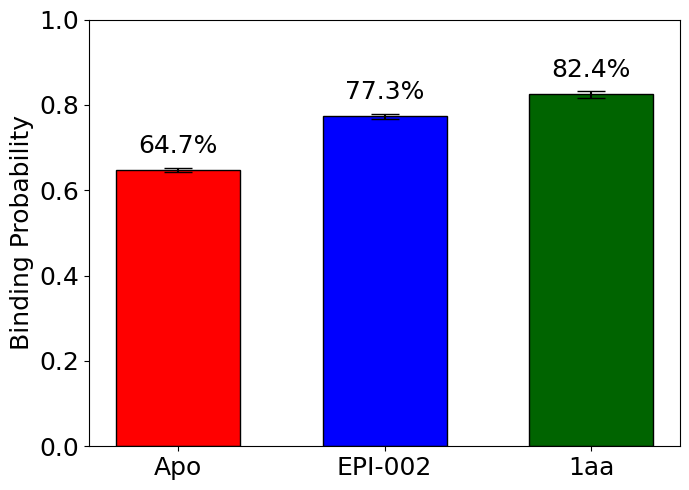

In [24]:
binding_probabilities = [apo_contact_prob, E2_contact_prob, AA_contact_prob]

# ---- Calculate block error ----
apo_binary = (apo_contact_CA >= 1).astype(float)
E2_binary = (E2_contact_CA >= 1).astype(float)
AA_binary = (AA_contact_CA >= 1).astype(float)

apo_err = np.sqrt(block(apo_binary) / len(apo_binary))*100
E2_err = np.sqrt(block(E2_binary) / len(E2_binary))*100
AA_err = np.sqrt(block(AA_binary) / len(AA_binary))*100

errors = [apo_err, E2_err, AA_err]
print(errors)
print(f"Binding probability ± error: {[(f'{p:.4f} ± {e:.4f}') for p, e in zip(binding_probabilities, errors)]}")
# ---- Plotting ----
labels = ['Apo', 'EPI-002', '1aa']
clist_old = ['red', 'blue', 'darkgreen']
x_positions = [0.75, 1.0, 1.25]

fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(x_positions, binding_probabilities, color=clist_old, width=0.15, edgecolor='black', zorder=1)

# Error bars
ax.errorbar(x_positions, binding_probabilities, yerr=errors, fmt='none', capsize=10, color='black', zorder=2)
# Labels & annotations
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, fontsize=18)
ax.set_ylabel('Binding Probability', fontsize=18)
ax.set_ylim(0, 1)
for i, value in enumerate(binding_probabilities):
    ax.text(x_positions[i], value + 0.04, f"{value*100:.1f}%", ha='center', fontsize=18)

plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig(outdir + 'binding_bar_err.pdf', dpi=300, bbox_inches='tight')
plt.show()

[0.005082184211225968, 0.006343675254566799, 0.009032498383390403]
Binding probability ± error: ['0.2493 ± 0.0051', '0.2972 ± 0.0063', '0.8243 ± 0.0090']


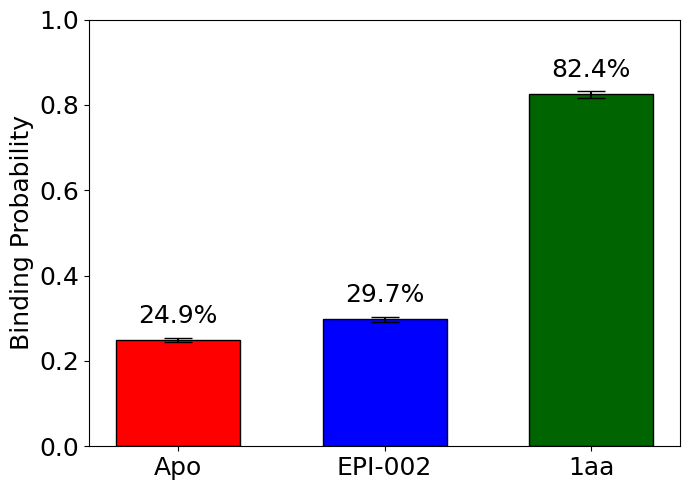

In [25]:
binding_probabilities = [apo_box_bf, E2_box_bf, AA_box_bf]

# ---- Calculate block error ----
apo_binary = (apo_contact_CA >= 1).astype(float)
E2_binary = (E2_contact_CA >= 1).astype(float)
AA_binary = (AA_contact_CA >= 1).astype(float)

apo_err = np.sqrt(block(apo_binary) / len(apo_binary))*100
E2_err = np.sqrt(block(E2_binary) / len(E2_binary))*100
AA_err = np.sqrt(block(AA_binary) / len(AA_binary))*100

errors = [apo_err, E2_err, AA_err]
print(errors)
print(f"Binding probability ± error: {[(f'{p:.4f} ± {e:.4f}') for p, e in zip(binding_probabilities, errors)]}")
# ---- Plotting ----
labels = ['Apo', 'EPI-002', '1aa']
clist_old = ['red', 'blue', 'darkgreen']
x_positions = [0.75, 1.0, 1.25]

fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(x_positions, binding_probabilities, color=clist_old, width=0.15, edgecolor='black', zorder=1)

# Error bars
ax.errorbar(x_positions, binding_probabilities, yerr=errors, fmt='none', capsize=10, color='black', zorder=2)
# Labels & annotations
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, fontsize=18)
ax.set_ylabel('Binding Probability', fontsize=18)
ax.set_ylim(0, 1)
for i, value in enumerate(binding_probabilities):
    ax.text(x_positions[i], value + 0.04, f"{value*100:.1f}%", ha='center', fontsize=18)

plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig(outdir + 'binding_bar_err.pdf', dpi=300, bbox_inches='tight')
plt.show()

Apo Kd = 0.001814 ± 0.000278 M
E2  Kd = 0.000980 ± 0.000257 M
AA  Kd = 0.000273 ± 0.000097 M
Binding probability ± error: ['0.0018 ± 0.0003', '0.0010 ± 0.0003', '0.0003 ± 0.0001']


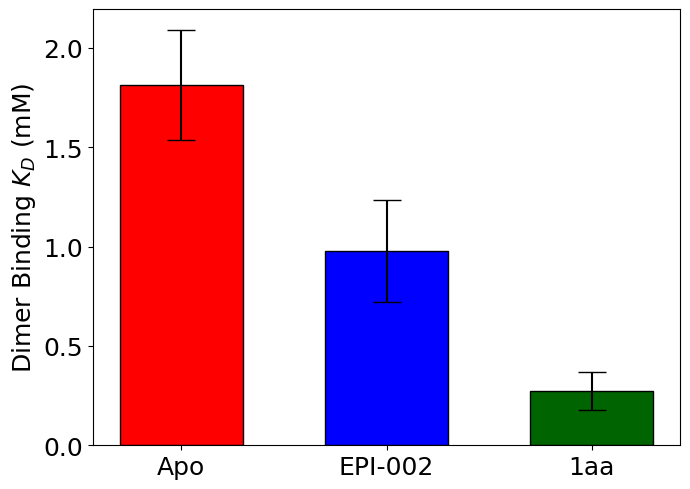

In [26]:
dimer_kd = [apo_dimer_kd, E2_dimer_kd, AA_dimer_kd]

def kd_error_from_block(binding_binary, concentration):
    mean, err = get_blockerror_pyblock_nanskip(binding_binary)
    kd_error = (concentration / (mean**2)) * err
    return kd_error

# ---- Calculate block error ----
apo_binary = (apo_contact_CA >= 1).astype(float)
E2_binary = (E2_contact_CA >= 1).astype(float)
AA_binary = (AA_contact_CA >= 1).astype(float)

apo_kd_error = kd_error_from_block(apo_binary, apo_conc)
E2_kd_error = kd_error_from_block(E2_binary, E2_conc)
AA_kd_error = kd_error_from_block(AA_binary, AA_conc)

print(f"Apo Kd = {apo_dimer_kd:.6f} ± {apo_kd_error:.6f} M")
print(f"E2  Kd = {E2_dimer_kd:.6f} ± {E2_kd_error:.6f} M")
print(f"AA  Kd = {AA_dimer_kd:.6f} ± {AA_kd_error:.6f} M")

errors = [apo_kd_error, E2_kd_error, AA_kd_error]
print(f"Binding probability ± error: {[(f'{p:.4f} ± {e:.4f}') for p, e in zip(dimer_kd, errors)]}")

# Convert Kd and error values from M to mM
dimer_kd_mM = [val * 1e3 for val in dimer_kd]
errors_mM = [err * 1e3 for err in errors]

# Plotting
labels = ['Apo', 'EPI-002', '1aa']
clist_old = ['red', 'blue', 'darkgreen']
x_positions = [0.75, 1.0, 1.25]

fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(x_positions, dimer_kd_mM, color=clist_old, width=0.15, edgecolor='black', zorder=1)

# Error bars
ax.errorbar(x_positions, dimer_kd_mM, yerr=errors_mM, fmt='none', capsize=10, color='black', zorder=2)

# Labels & annotations
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, fontsize=18)
ax.set_ylabel('Dimer Binding $K_D$ (mM)', fontsize=18)
ax.tick_params(labelsize=18)

# for i, value in enumerate(dimer_kd_mM):
#     ax.text(x_positions[i], value - 0.4, f"{value:.2f}", ha='center', fontsize=18)

plt.tight_layout()
plt.savefig(outdir + 'kd_bar_err_mM.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [27]:
# --- Plotting results ---
def contiguous_bool(data: np.ndarray = None,
                    condition: "a python function that returns true when a condition on data is met" = None,
                    bools: np.ndarray = None) -> list:
    """returns a list of numpy arrays containing the indices
    (of the zeroth dim) of data where a condition is met contiguously"""

    assert ~all(i is None for i in (bools, condition)), "Must provide condition or bools"

    if condition is not None:
        assert data is not None, "If a callable condition is given, must provide data to operate on"

    bools = np.insert(bools.astype(int) if bools is not None else condition(data).astype(int), 0, 0)

    idx = np.insert(np.arange(len(bools) - 1), 0, 0)

    comp = np.stack([idx, bools], axis=1)

    return [i[:, 0][1:] if len(i) > 1 else i[:, 0] for i in
            filter(lambda x: any(x[:, 1] != 0), np.split(comp, np.where(comp[:, 1] == 0)[0]))]

contact = md.compute_distances(E2_trj, CA_pairs)
contacts = np.asarray(contact).astype(float)
bools = contacts.min(1)<0.6
events = contiguous_bool(bools =bools)
times = np.fromiter(map(len, events), int) * (stride_n*0.24)
# plt.hist(times, bins=100, density=True)
indices_of_longest_event = events[times.argmax()]

In [28]:
indices_of_longest_event

array([275092, 275093, 275094, ..., 288513, 288514, 288515])

In [29]:
E2_trj[indices_of_longest_event].save_dcd(outdir+"E2_longest_event.dcd")

In [30]:
E2_event_length.max()

15073.92

<Figure size 640x480 with 0 Axes>

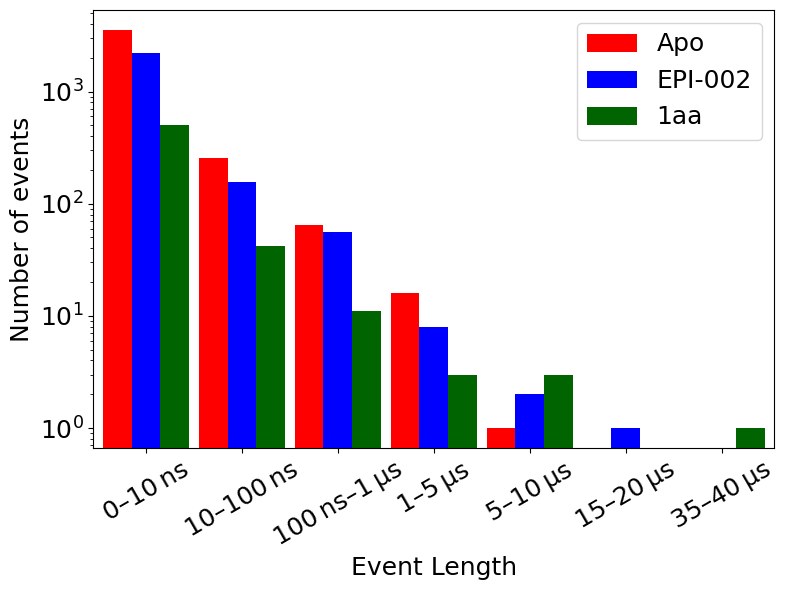

In [31]:
plt.clf()

# Define bin edges and labels
bin_edges = [0, 10, 100, 1000, 5000, 10000, 35000, 40000]
bin_labels = ['0–10 ns', '10–100 ns', '100 ns–1 µs', '1–5 µs', '5–10 µs', '15–20 µs', '35–40 µs']

# Compute histogram counts
apo_counts_all, _ = np.histogram(apo_event_length, bins=bin_edges)
E2_counts_all, _ = np.histogram(E2_event_length, bins=bin_edges)
AA_counts_all, _ = np.histogram(AA_event_length, bins=bin_edges)

selected_indices = [0, 1, 2, 3, 4, 5, 6]
apo_counts = apo_counts_all[selected_indices]
E2_counts = E2_counts_all[selected_indices]
AA_counts = AA_counts_all[selected_indices]

# Bin positions
bin_centers = np.arange(len(bin_labels))  # Tick positions

# Bar setup
bar_width = 0.3
offsets = [-bar_width, 0, bar_width]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(bin_centers + offsets[0], apo_counts, width=bar_width, label='Apo', color=clist_old[0])
plt.bar(bin_centers + offsets[1], E2_counts, width=bar_width, label='EPI-002', color=clist_old[1])
plt.bar(bin_centers + offsets[2], AA_counts, width=bar_width, label='1aa', color=clist_old[2])

# Set ticks at bin centers
plt.xticks(bin_centers, bin_labels, fontsize=14, rotation=30)

# Set xlim to fit full bar range (left edge of leftmost bar to right edge of rightmost bar)
left_edge = bin_centers[0] + offsets[0] - bar_width / 2
right_edge = bin_centers[-1] + offsets[2] + bar_width / 2
plt.xlim(left_edge-0.1, right_edge+0.1)

# Other aesthetics
plt.yscale('log')
plt.xlabel('Event Length', fontsize=18)
plt.ylabel('Number of events', fontsize=18)
plt.tick_params(labelsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

# Save if needed
plt.savefig(outdir + 'Tau5_R2_binding_selectedbins.pdf', dpi=300)
# plt.savefig(outdir + 'Tau5_R2_binding_selectedbins.svg', dpi=300)
plt.show()

In [32]:
# --- Calculate statistical measures ---
# Define aromatic proton names for TRP and TYR residues
AROMATIC_PROTONS = {
    "TRP": ["HD1", "HH2", "HZ3"],
    "TYR": ["HD1", "HD2", "HE1", "HE2"]
}

def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    # print(average,Data,len(Data))
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        # print(opt)
        # print(math.isnan(opt))
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)

def get_aromatic_proton_indices(topology):
    """
    Extracts the indices of aromatic protons from TRP and TYR residues in the topology.
    """
    aromatic_proton_indices = {ptype: [] for ptype in AROMATIC_PROTONS.keys()}
    for residue in topology.residues:
        if residue.name in AROMATIC_PROTONS:
            for atom in residue.atoms:
                if atom.name in AROMATIC_PROTONS[residue.name]:
                    aromatic_proton_indices[residue.name].append(atom.index)
    return aromatic_proton_indices

def compute_noe_density_with_blocking(traj_file, top_file, cutoff=0.6, monomer_separation=None, bound_frac=1.0):
    """
    Compute NOE proton density and blocking error using pyblock.
    For each aromatic proton, contacts are computed only with protons from the *opposite* monomer.

    Returns:
    - noe_densities: dict of average contact densities (normalized)
    - noe_errors: dict of blocking error (normalized)
    """

    traj = md.load(traj_file, top=top_file, stride=10)
    topology = traj.topology
    total_atoms = traj.n_atoms

    # Get all aromatic protons grouped by residue type
    aromatic_proton_indices = get_aromatic_proton_indices(topology)
    all_protons = [atom.index for atom in topology.atoms if atom.element.symbol == 'H']

    # Define helper to check if two atoms are in the same monomer
    def is_same_monomer(index_a, index_b):
        half = total_atoms // 2
        return (index_a < half and index_b < half) or (index_a >= half and index_b >= half)

    noe_densities = {}
    noe_errors = {}

    for residue, protons in aromatic_proton_indices.items():
        all_traces = []

        for arom_proton in protons:
            arom_atom = topology.atom(arom_proton)
            arom_name = f"{arom_atom.residue} {arom_atom.name} (index {arom_proton})"

            # Dynamically determine opposite monomer protons for this aromatic proton
            opposite_protons = [h for h in all_protons if not is_same_monomer(arom_proton, h)]

            # Identify which of these are ever within cutoff distance
            pair_indices = [[arom_proton, h] for h in opposite_protons]
            distances = md.compute_distances(traj, pair_indices)
            contact_mask = np.any(distances < cutoff, axis=0)
            included_opposite_protons = [opposite_protons[i] for i, keep in enumerate(contact_mask) if keep]

            print(f"\n[{arom_name}] → Proximity-based contacts with:")
            for opp_idx in included_opposite_protons:
                opp_atom = topology.atom(opp_idx)
                print(f"  - {opp_atom.residue} {opp_atom.name} (index {opp_atom.index})")

            # Compute time series of contact counts per frame
            contacts_per_frame = np.sum(distances < cutoff, axis=1)
            all_traces.append(contacts_per_frame)

        # Block averaging for all traces of this residue type
        all_traces = np.vstack(all_traces)
        mean_vals = []
        block_errs = []

        for trace in all_traces:
            mean, err = get_blockerror_pyblock_nanskip(trace)
            mean_vals.append(mean / bound_frac)
            block_errs.append(err / bound_frac)

        noe_densities[residue] = mean_vals
        noe_errors[residue] = block_errs

    return noe_densities, noe_errors

# Example usage:
# Define a function to distinguish monomers (modify based on your system)
def monomer_separation(atom_index):
    # Example: Suppose the first half of atoms belong to monomer 1, and the second half to monomer 2
    total_atoms = 676  # Adjust based on your topology
    return atom_index >= total_atoms // 2  # Assume monomer 2 starts after half of the atoms

# Run analysis
apo_traj_file = apo_dcd
E2_traj_file = E2_dcd
top_file = pdb
bound_frac = 1.0  # Adjust based on your system

apo_noe_results, apo_noe_errors = compute_noe_density_with_blocking(
    apo_traj_file, top_file, cutoff=0.6, monomer_separation=monomer_separation, bound_frac=bound_frac)

E2_noe_results, E2_noe_errors = compute_noe_density_with_blocking(
    E2_traj_file, top_file, cutoff=0.6, monomer_separation=monomer_separation, bound_frac=bound_frac)



[TRP7 HD1 (index 95)] → Proximity-based contacts with:
  - ACE26 H1 (index 338)
  - ACE26 H2 (index 340)
  - ACE26 H3 (index 341)
  - LEU27 H (index 345)
  - LEU27 HA (index 347)
  - LEU27 HB3 (index 349)
  - LEU27 HB2 (index 350)
  - LEU27 HG (index 352)
  - LEU27 HD11 (index 354)
  - LEU27 HD12 (index 355)
  - LEU27 HD13 (index 356)
  - LEU27 HD21 (index 358)
  - LEU27 HD22 (index 359)
  - LEU27 HD23 (index 360)
  - ASP28 H (index 364)
  - ASP28 HA (index 366)
  - ASP28 HB3 (index 368)
  - ASP28 HB2 (index 369)
  - TYR29 H (index 376)
  - TYR29 HA (index 378)
  - TYR29 HB3 (index 380)
  - TYR29 HB2 (index 381)
  - TYR29 HD1 (index 384)
  - TYR29 HE1 (index 386)
  - TYR29 HH (index 389)
  - TYR29 HE2 (index 391)
  - TYR29 HD2 (index 393)
  - GLY30 H (index 397)
  - GLY30 HA3 (index 399)
  - GLY30 HA2 (index 400)
  - SER31 H (index 404)
  - SER31 HA (index 406)
  - SER31 HB3 (index 408)
  - SER31 HB2 (index 409)
  - SER31 HG (index 411)
  - ALA32 H (index 415)
  - ALA32 HA (index 417)

Trp (H$\delta_1$)
  Apo: 3.1193 ± 0.4114
  EPI-002: 4.8294 ± 0.9209
Tyr (H$\delta_{1/2}$) or Trp (H$\zeta_3$)
  Apo: 11.9429 ± 0.8478
  EPI-002: 19.3499 ± 1.9898
Tyr (H$\varepsilon_{1/2}$)
  Apo: 4.4267 ± 0.3631
  EPI-002: 7.4312 ± 0.6580


/tmp/ipykernel_12970/1149631637.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Apo", "EPI-002"], fontsize=16)


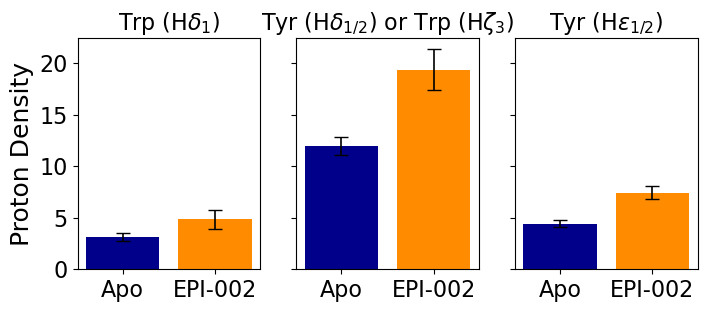

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
plt.rcParams["text.usetex"] = False

# Final merged NOE groups with Greek-labeled subplot titles
merged_groups = {
    r"Trp (H$\delta_1$)": {
        "residues": ["TRP"],
        "protons": ["HD1"]
    },
    r"Tyr (H$\delta_{1/2}$) or Trp (H$\zeta_3$)": {
        "residues": ["TYR", "TRP"],
        "protons": ["HD1", "HD2", "HZ3"]
    },
    r"Tyr (H$\varepsilon_{1/2}$)": {
        "residues": ["TYR"],
        "protons": ["HE1", "HE2"]
    }
}

axes = axes.flatten()

sim_vals = []
sim_errs = []
for i, (label, group) in enumerate(merged_groups.items()):
    apo_vals = []
    apo_errs = []
    E2_vals = []
    E2_errs = []

    for resname in group["residues"]:
        for j, proton in enumerate(AROMATIC_PROTONS[resname]):
            if proton in group["protons"]:
                apo_vals.append(apo_noe_results[resname][j])
                apo_errs.append(apo_noe_errors[resname][j])
                E2_vals.append(E2_noe_results[resname][j])
                E2_errs.append(E2_noe_errors[resname][j])

    ax = axes[i]

    if not apo_vals or not E2_vals:
        ax.axis("off")
        continue

    # Calculate means and error propagation
    apo_mean = np.sum(apo_vals)
    E2_mean = np.sum(E2_vals)
    apo_sem = np.sqrt(np.sum(np.square(apo_errs)))
    E2_sem = np.sqrt(np.sum(np.square(E2_errs)))
    
    ax.bar(["Apo", "EPI-002"],
           [apo_mean, E2_mean],
           yerr=[apo_sem, E2_sem],
           color=["darkblue", "darkorange"],
           capsize=5, ecolor='black', error_kw={'elinewidth': 1.2})

    print(f"{label}\n  Apo: {apo_mean:.4f} ± {apo_sem:.4f}\n  EPI-002: {E2_mean:.4f} ± {E2_sem:.4f}")
    sim_vals.append([apo_mean, E2_mean])
    sim_errs.append([apo_sem, E2_sem])

    ax.set_title(label, fontsize=16)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xticklabels(["Apo", "EPI-002"], fontsize=16)

    if i == 0:
        ax.set_ylabel("Proton Density", fontsize=18)
    else:
        ax.set_ylabel("")

plt.show()
# plt.savefig(outdir + 'NOE_density_merged.pdf', dpi=300, bbox_inches='tight')

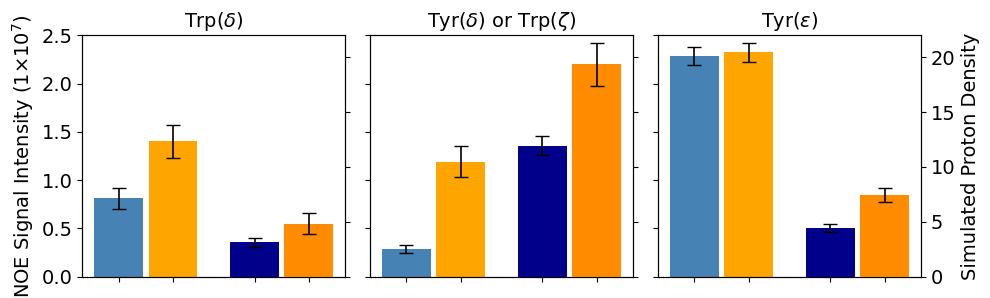

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

merged_groups = {
    r"Trp($\delta$)": {
        "sim_vals": [sim_vals[0][0], sim_vals[0][1]],
        "sim_err":  [sim_errs[0][0], sim_errs[0][1]],
        "exp_vals": [8.13e6, 1.40e7],
        "exp_err":  [1.084295e6, 1.752398e6]
    },
    r"Tyr($\delta$) or Trp($\zeta$)": {
        "sim_vals": [sim_vals[1][0], sim_vals[1][1]],
        "sim_err":  [sim_errs[1][0], sim_errs[1][1]],
        "exp_vals": [2.86e6, 1.19e7],
        "exp_err":  [4.084170e5, 1.632425e6]
    },
    r"Tyr($\varepsilon$)": {
        "sim_vals": [sim_vals[2][0], sim_vals[2][1]],
        "sim_err":  [sim_errs[2][0], sim_errs[2][1]],
        "exp_vals": [2.2875602e7, 2.3239409e7],
        "exp_err":  [9.531501e5, 9.995445e5]
    }
}


colors_exp = ["steelblue", "orange"]
colors_sim = ["darkblue", "darkorange"]
labels_all = ["Apo", "EPI-002", "Apo", "EPI-002"]

# Bar positions (gap between experimental and simulation)
x_exp = np.array([-0.3, -0.1])
x_sim = np.array([0.2, 0.4])

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=False)
plt.rcParams["text.usetex"] = False

for i, (title, data) in enumerate(merged_groups.items()):
    ax1 = axes[i]  # Experimental axis
    ax2 = ax1.twinx()  # Simulated axis

    # Experimental bars
    ax1.bar(x_exp, data["exp_vals"], width=0.18, color=colors_exp,
            yerr=data["exp_err"], capsize=5, ecolor='black', error_kw={'elinewidth': 1.2})
    ax1.set_ylim(0, 2.5e7)
    ax1.ticklabel_format(style='plain')
    ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=False, useOffset=False))
    ax1.yaxis.offsetText.set_visible(False)
    if i == 0:
        ax1.set_ylabel(r"NOE Signal Intensity (1$\times$10$^7$)", fontsize=14, color='black')
        ax1.tick_params(axis='y', labelsize=14, labelcolor='black')
    else:
        ax1.set_ylabel("")
        ax1.set_yticklabels([])

    # Simulated bars with error bars
    ax2.bar(x_sim, data["sim_vals"], width=0.18, color=colors_sim,
            yerr=data["sim_err"], capsize=5, ecolor='black', error_kw={'elinewidth': 1.2})
    ax2.set_ylim(0, 22)
    if i == 2:
        ax2.set_ylabel("Simulated Proton Density", fontsize=14, color='black')
        ax2.tick_params(axis='y', labelsize=14, labelcolor='black')
    else:
        ax2.set_ylabel("")
        ax2.set_yticklabels([])
        

    # X-axis setup
    ax1.set_xticks(np.concatenate([x_exp, x_sim]))
    ax1.set_xticklabels([])
    ax1.set_title(title, fontsize=14)

# Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=c) for c in colors_exp + colors_sim]
# fig.legend(handles, labels_all, loc="upper center", ncol=4, fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.savefig(outdir + "noe_comparison_merged.pdf", dpi=300)
plt.show()
